In [1]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV

import statsmodels.formula.api as smf

from linearmodels.panel import PanelOLS


# Data Manipulation 

In [2]:
# Sustainable development atlas of Bolivia 

bol = pd.read_csv("/Users/hendrixperalta/Desktop/bolivia/data/sdg_atlas_bolivia/GeoDS4Bolivia.csv")
bol = bol.rename(columns={"asdf_id":"id"})
#list(bol.columns)

# Remote sensing data 

sat = pd.read_csv("data/satellite/satelite_data.csv")
#list(sat.columns)

In [3]:
# creating a dataframe with only the composite sdg indexes

sdg_indexes = bol[["id", 'mun_id' , 'index_sdg1','index_sdg2','index_sdg3','index_sdg4','index_sdg5','index_sdg6','index_sdg7', 'index_sdg8','index_sdg9','index_sdg10',
               'index_sdg11','index_sdg13','index_sdg15','index_sdg16','index_sdg17', "imds",]]

                  
#sdg_indexes.isna().sum()

# Export the index variables 
#sdg_indexes.to_csv("data/sdg_prediction/sdg_indexes.csv")

In [4]:
# Create a dataframe with only satellite data

# Satellite data from the Bolivia dataset 

satellite_full = bol[["id", 'mun_id' ,
                'tr400_pop2012','tr400_pop2013','tr400_pop2014','tr400_pop2015','tr400_pop2016','tr400_pop2017','tr400_pop2018','tr400_pop2019','tr400_pop2020',
                
                "ln_t400NTLpc2012",'ln_t400NTLpc2013','ln_t400NTLpc2014','ln_t400NTLpc2015','ln_t400NTLpc2016','ln_t400NTLpc2017','ln_t400NTLpc2018','ln_t400NTLpc2019',
                'ln_t400NTLpc2020',]]

# Other satellite data
sat_filtered = sat[["id", 
                    'egdp2012','egdp2013','egdp2014','egdp2015','egdp2016','egdp2017','egdp2018','egdp2019',
                   
                    'agr_land2012','agr_land2013','agr_land2014','agr_land2015','agr_land2016','agr_land2017','agr_land2018','agr_land2019','agr_land2020',
                   
                    'urb_land2012','urb_land2013','urb_land2014','urb_land2015','urb_land2016','urb_land2017','urb_land2018','urb_land2019',
                   
                    'pm25_2012',
                    
                    'land_temp2012',]]

# Merging the satellite dataframes 
satellite_full = satellite_full.merge(sat_filtered, on="id", how="outer")

# Export satellite data
#satellite_full.to_csv("data/sdg_prediction/satellite_full.csv")

#list(satellite_full.columns)

In [15]:
# Creation of the satellite dataframe
offset = 1000  

sat_mod = pd.DataFrame()
# ID 
sat_mod["id"] = satellite_full["id"]

# Log EGDP per capita - sum EGDP
satellite_full["EGDPpc2012"] = (satellite_full["egdp2012"]*1000000/ bol["tr400_pop2012"])
sat_mod["lnEGDPpc2012"] = np.log(satellite_full["EGDPpc2012"])

# Land cover agriculture/urban
sat_mod["lnagr_land2012"] = np.log(satellite_full["agr_land2012"] + offset)
sat_mod["lnurb_land2012"] = np.log(satellite_full["urb_land2012"] + offset)

# Urban landcover percentage
satellite_full["total_land2012"] = satellite_full["agr_land2012"] + satellite_full["urb_land2012"]
satellite_full["perUrb_land2012"] = satellite_full["urb_land2012"] / satellite_full["total_land2012"]
sat_mod["ln_perUrb_land2012"] = np.log(satellite_full["perUrb_land2012"].fillna(0) + offset)

# Population
sat_mod["ln_tr400_pop2012"] = np.log(satellite_full["tr400_pop2012"])

# PM2.5
sat_mod["ln_pm25_2012"] = np.log(satellite_full["pm25_2012"])

# Surface temperature
sat_mod["ln_land_temp2012"] = np.log(satellite_full["land_temp2012"])

# NTL

sat_mod["ln_t400NTLpc2012"] = satellite_full[["ln_t400NTLpc2012"]]

#sat_mod.to_csv("data/sdg_prediction/sat_mod.csv")

In [16]:
#Standarizing the labels

sta_indicators = bol[['sdg1_4_abs', 'sdg1_1_dtl_abs', 'sdg1_1_pubn_abs', 'sdg1_2_dd_abs',
               'sdg1_4_ebs_abs', 'sdg2_2_cm_abs', 'sdg2_2_wow_abs', 'sdg2_4_apu_abs',
               'sdg2_4_tm_abs', 'sdg3_2_fb_abs', 'sdg3_2_ffb_abs', 'sdg3_3_cd_abs',
               'sdg3_3_pd_abs', 'sdg3_3_mc_abs', 'sdg3_3_tc_abs', 'sdg3_3_vih_abs',
               'sdg3_7_bpw_abs', 'sdg4_1_mhs_abs', 'sdg4_1_fhs_abs', 'sdg4_4_heu_abs',
               'sdg4_6_pnl_abs', 'sdg4_c_uti_abs', 'sdg4_c_uts_abs', 'sdg6_1_wdc_abs',
               'sdg6_2_bsc_abs', 'sdg7_1_wec_abs', 'sdg7_1_rec_abs', 'sdg7_1_cec_abs',
               'sdg7_3_tee_abs', 'sdg8_4_rem_abs', 'sdg8_5_ompr_abs',
               'sdg8_5_ofpr_abs', 'sdg8_6_mlm_abs', 'sdg8_6_wlm_abs',
               'sdg8_10_dbb_abs', 'sdg9_1_rmun_abs', 'sdg9_5_kcd_abs',
               'sdg9_5_eutf_abs', 'sdg9_c_hf_abs', 'sdg9_c_tr_abs', 'sdg10_2_dss_abs',
               'sdg11_1_ho_abs', 'sdg11_1_wos_abs', 'sdg11_2_mtv_abs',
               'sdg13_2_tco2_abs', 'sdg13_2_ad_abs', 'sdg15_1_pa_abs',
               'sdg15_5_rl_abs', 'sdg16_1_rh_abs', 'sdg16_6_aob_abs',
               'sdg16_9_ncr_abs', 'sdg17_5_tpi_abs', 'sdg1_4_abs_norm',
               'index_sdg1','index_sdg2','index_sdg3','index_sdg4','index_sdg5','index_sdg6','index_sdg7',
               'index_sdg8','index_sdg9','index_sdg10','index_sdg11','index_sdg13','index_sdg15',
               'index_sdg16','index_sdg17']]

# Standarizing the labels 

sta_indicators = (sta_indicators - sta_indicators.mean())/sta_indicators.std()
#norm_df = (norm_df - norm_df.min()) / (norm_df.max()-norm_df.min())
sta_indicators = sta_indicators.reset_index()
sta_indicators = sta_indicators.rename(columns = {"index":"id"})

# Export the standarized sdg indicators 
#sta_indicators.to_csv("data/sdg_prediction/sta_indicators.csv")

## Descriptive statistics

In [17]:
# Merging the labels and features datasets 

desc_df = sat_mod.merge(sta_indicators, on="id", how="outer")
desc_df = desc_df = desc_df.drop("id", axis=1)
desc_table = desc_df.describe().round(2)
desc_table = desc_table.transpose()
desc_table
#desc_table.to_csv("description_statistics.csv")

,count,mean,std,min,25%,50%,75%,max
lnEGDPpc2012,339.0,8.40,1.24,4.71,7.53,8.24,9.16,11.69
lnagr_land2012,339.0,6.97,0.18,6.91,6.91,6.91,6.94,8.37
lnurb_land2012,339.0,7.00,0.39,6.91,6.91,6.91,6.93,10.27
ln_perUrb_land2012,339.0,6.91,0.00,6.91,6.91,6.91,6.91,6.91
ln_tr400_pop2012,339.0,9.34,1.15,6.25,8.69,9.29,9.90,14.17
...,...,...,...,...,...,...,...,...
index_sdg11,339.0,-0.00,1.00,-2.75,-0.62,-0.07,0.47,4.57
index_sdg13,339.0,0.00,1.00,-3.89,-0.47,0.34,0.63,1.78
index_sdg15,339.0,0.00,1.00,-2.86,-0.22,-0.21,-0.02,2.45
index_sdg16,339.0,0.00,1.00,-4.25,-0.49,0.19,0.68,2.05


# **Data exploration**

In [18]:
sat_mod.describe().round(2)

,id,lnEGDPpc2012,lnagr_land2012,lnurb_land2012,ln_perUrb_land2012,ln_tr400_pop2012,ln_pm25_2012,ln_land_temp2012,ln_t400NTLpc2012
count,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00,339.00
mean,169.00,8.40,6.97,7.00,6.91,9.34,3.12,5.70,13.03
std,98.01,1.24,0.18,0.39,0.00,1.15,0.29,0.01,1.67
min,0.00,4.71,6.91,6.91,6.91,6.25,2.11,5.66,0.86
25%,84.50,7.53,6.91,6.91,6.91,8.69,2.89,5.69,12.05
50%,169.00,8.24,6.91,6.91,6.91,9.29,3.09,5.70,13.12
75%,253.50,9.16,6.94,6.93,6.91,9.90,3.36,5.71,14.27
max,338.00,11.69,8.37,10.27,6.91,14.17,3.65,5.72,17.07


In [19]:
sat_mod

,id,lnEGDPpc2012,lnagr_land2012,lnurb_land2012,ln_perUrb_land2012,ln_tr400_pop2012,ln_pm25_2012,ln_land_temp2012,ln_t400NTLpc2012
0,0,8.778138,6.907755,6.907755,6.907755,7.844864,2.638050,5.708126,11.414175
1,1,8.785445,6.907755,6.907755,6.907755,8.317810,2.862391,5.699496,12.862933
2,2,9.205926,6.907755,6.907755,6.907755,7.985663,2.725861,5.703597,12.547255
3,3,7.469730,6.956808,7.086000,6.908550,10.633700,3.088530,5.695546,14.310976
4,4,7.399987,6.907755,6.907755,6.907755,9.122021,3.113783,5.691382,11.612880
...,...,...,...,...,...,...,...,...,...
334,334,9.215343,6.907755,6.909009,6.908755,8.825623,2.955532,5.706426,11.950671
335,335,8.702200,6.915808,6.907755,6.907755,10.339062,2.713497,5.700500,12.346036
336,336,8.251013,6.936421,6.907755,6.907755,9.698804,2.773218,5.698469,13.437716
337,337,8.128326,6.907755,7.185977,6.908755,10.743873,2.763397,5.702828,13.671997


In [20]:
reg_data = sat_mod.merge(sdg_indexes[["id","imds"]], on="id", how="outer")

mod = smf.ols("imds ~  ln_t400NTLpc2012 + ln_tr400_pop2012 + lnEGDPpc2012 + ln_pm25_2012 ", 
              data=reg_data)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   imds   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     52.92
Date:                Wed, 26 Jun 2024   Prob (F-statistic):           1.65e-34
Time:                        00:22:40   Log-Likelihood:                -1045.7
No. Observations:                 339   AIC:                             2101.
Df Residuals:                     334   BIC:                             2121.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           11.8725      4.370  

In [21]:
missing_labels = sdg_indexes.columns[sdg_indexes.isna().any()]
missing_labels

Index([], dtype='object')

In [ ]:
#plt.style.available

[Text(0.5, 1.0, 'PM25')]

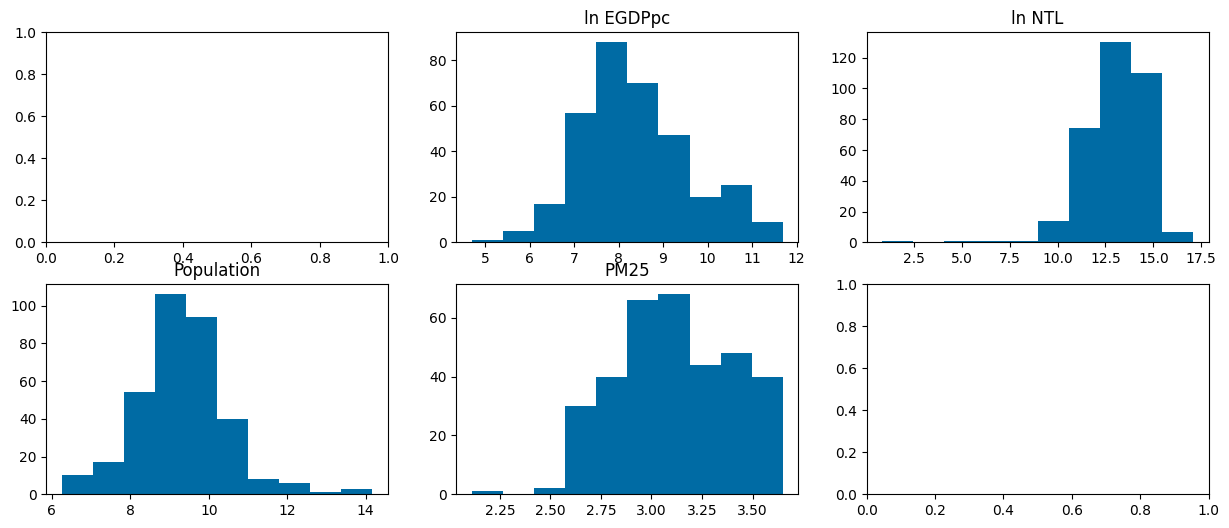

In [23]:
plt.style.use("tableau-colorblind10")

fig, ((ax0, ax1, ax2),(ax3, ax4, ax5)) = plt.subplots(nrows=2,
                                                     ncols=3,
                                                     figsize=(15,6)
                                                     )
#ax0.hist(df["perUrb_land"])
#ax0.set(title="Percentage of Urban Land")

ax1.hist(reg_data["lnEGDPpc2012"])
ax1.set(title="ln EGDPpc")

ax2.hist(reg_data["ln_t400NTLpc2012"])
ax2.set(title="ln NTL")

ax3.hist(reg_data["ln_tr400_pop2012"])
ax3.set(title= "Population")

ax4.hist(reg_data["ln_pm25_2012"])
ax4.set(title= "PM25")

#ax5.hist(df["land_temp2012"])
#ax5.set(title= "Land Surface Temperature");


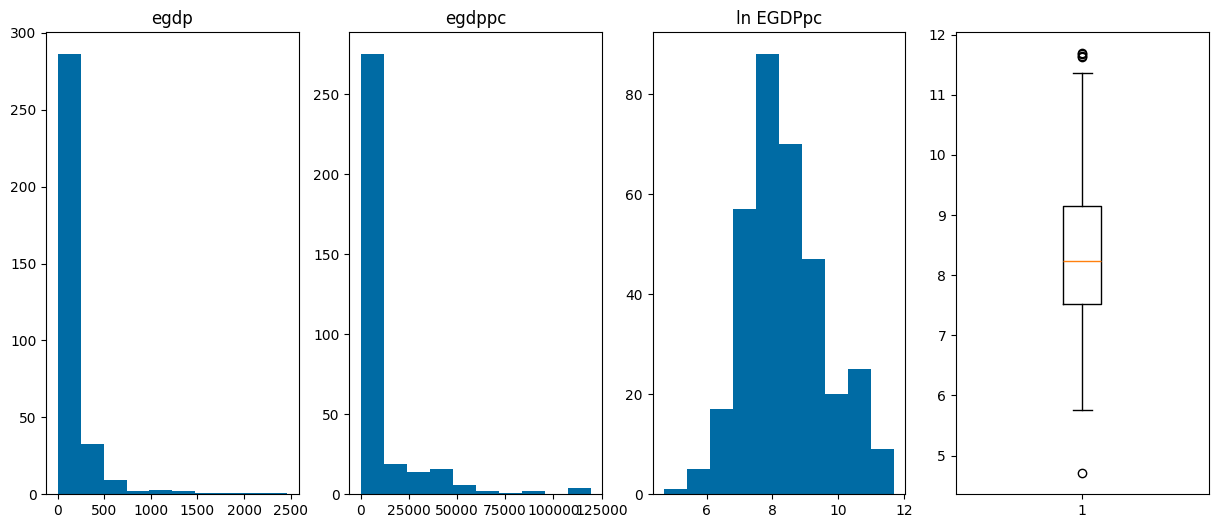

In [26]:
plt.style.use("tableau-colorblind10")

fig, (ax0, ax1, ax2, ax4) = plt.subplots(nrows=1,
                                 ncols=4,
                                 figsize=(15,6)
                                 )
ax0.hist(sat["egdp2012"])
ax0.set(title="egdp")

ax1.hist(satellite_full["EGDPpc2012"])
ax1.set(title= "egdppc")

ax2.hist(sat_mod["lnEGDPpc2012"])
ax2.set(title="ln EGDPpc")

ax4.boxplot(sat_mod["lnEGDPpc2012"]);


In [ ]:
plt.style.available

In [ ]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="lnEGDPpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")



In [ ]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["lnEGDPpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["lnEGDPpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

In [ ]:

fig, (ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=2,
                                    figsize=(15,7))

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['imds'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="imds")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]), "r-")

#----- ax2
ax2.scatter(x=short_df["lnEGDPpc2012"], y=short_df['imds'])
ax2.set(xlabel="lnEGDPpc2012", ylabel="imds");

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['imds'], 1)
p = np.poly1d(z)
ax2.plot(short_df["lnEGDPpc2012"], p(short_df["lnEGDPpc2012"]), "r-")

In [ ]:
ntl_imds = short_df["ln_t400NTLpc2012"].corr(short_df['imds'])
egdp_imds = short_df["lnEGDPpc2012"].corr(short_df['imds'])

print(f"Correlation of ntl and imds: {ntl_imds}")
print(f"Correlation of egdp and imds: {egdp_imds}")

In [ ]:
plt.style.use("seaborn-v0_8")

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize=(15,7))
#----- ax0
ax0.scatter(x=short_df['lnEGDPpc2012'], y=short_df["ln_t400NTLpc2012"])
ax0.set(xlabel="lnEGDPpc2012", ylabel="ln_t400NTLpc2012")

# add trendline
z = np.polyfit(short_df["lnEGDPpc2012"], short_df['ln_t400NTLpc2012'], 1)
p = np.poly1d(z)
ax0.plot(short_df["lnEGDPpc2012"],p(short_df["lnEGDPpc2012"]),"r-")

#----- ax1
ax1.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['ln_tr400_pop2012'])
ax1.set(xlabel="ln_t400NTLpc2012", ylabel="ln_tr400_pop2012")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['ln_tr400_pop2012'], 1)
p = np.poly1d(z)
ax1.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]),"r-")

#----- ax2
ax2.scatter(x=short_df["ln_t400NTLpc2012"], y=short_df['ln_perUrb_land'])
ax2.set(xlabel="ln_t400NTLpc2012", ylabel="ln_perUrb_land")

# add trendline
z = np.polyfit(short_df["ln_t400NTLpc2012"], short_df['ln_perUrb_land'], 1)
p = np.poly1d(z)
ax2.plot(short_df["ln_t400NTLpc2012"],p(short_df["ln_t400NTLpc2012"]),"r-");



In [ ]:
egdp_ntl = short_df["lnEGDPpc2012"].corr(short_df['ln_t400NTLpc2012'])
egdp_pop = short_df["ln_t400NTLpc2012"].corr(short_df['ln_tr400_pop2012'])
egdp_urb = short_df["ln_t400NTLpc2012"].corr(short_df['ln_perUrb_land'])

print(f"Correlation of egdp and ntl: {egdp_ntl}")
print(f"Correlation of egdp and pop: {egdp_pop}")
print(f"Correlation of egdp and Urban land %: {egdp_urb}")

# **Regression models**

### Linear model

In [ ]:
x = df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
y = df['imds']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

model = LinearRegression()


# r2 
#lr = model.score(x_test, y_test)
lr = np.mean(cross_val_score(model, x, y))

# MAE
lr_mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))

model.fit(x_train,y_train)
lr_y_pred = model.predict(x_test)


### Ridge  model

In [ ]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rid_model = linear_model.Ridge()

# r2
ri = np.mean(cross_val_score(rid_model, x, y))

# MAE
ri_mae = np.mean(cross_val_score(rid_model, x, y, scoring="neg_mean_absolute_error"))

rid_model.fit(x_train, y_train)
ri_y_pred = rid_model.predict(x_test)

### Random Forest Regressor model

In [ ]:

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

rf_model = RandomForestRegressor()

# r2
rf = np.mean(cross_val_score(rf_model, x, y))

# MAE
rf_mae = np.mean(cross_val_score(rf_model, x, y, scoring="neg_mean_absolute_error"))

rf_model.fit(x_train, y_train)
rf_y_pred = rf_model.predict(x_test)

### Results 

In [ ]:
print("R2 for the regressor models")
print(f" Linear model  cv ->   R2: {lr*100:.2f}%,  MAE: {lr_mae:.2f}")
print(f" Ridger model  cv ->   R2: {ri*100:.2f}%,  MAE: {ri_mae:.2f}")
print(f" RF model      cv ->   R2: {rf*100:.2f}%,  MAE: {rf_mae:.2f} ")

### Correlation between prediction and truth data

In [ ]:
fig, (ax0, ax1, ax2) = plt.subplots(nrows=1,
                                    ncols=3,
                                    figsize = (15, 6))

ax0.scatter(x = y_test, y = lr_y_pred)
ax0.set(xlabel="SDI", ylabel="SDI Prediction", title="Linear Regression")

# add trendline
z = np.polyfit(y_test, lr_y_pred, 1)
p = np.poly1d(z)
ax0.plot(y_test,p(y_test),"r-")


ax1.scatter(x=y_test, y = ri_y_pred)
ax1.set(xlabel="SDI", ylabel="SDI Prediction", title="Ridge")

# add trendline
z = np.polyfit(y_test, ri_y_pred, 1)
p = np.poly1d(z)
ax1.plot(y_test,p(y_test),"r-")


ax2.scatter(x=y_test, y=rf_y_pred)
ax2.set(xlabel="SDI", ylabel="SDI Prediction", title="Random Forest")


# add trendline
z = np.polyfit(y_test, rf_y_pred, 1)
p = np.poly1d(z)
ax2.plot(y_test,p(y_test),"r-")


# **Categorical analysis**

In [ ]:
quantile_labels = ["low", 'medium-low', 'medium-high', 'high']
df["imds_quantile"] = pd.qcut(df["imds"], q=4, labels=quantile_labels)
#df["imds_quantile"]

In [ ]:
x = df[["ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012', 'lnagr_land2012', 'lnurb_land2012']].fillna(0)
y = df['imds_quantile']

np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

clf = RandomForestClassifier()
#clf.get_params()
clf.fit(x_train,y_train);

y_preds = clf.predict(x_test)

#evaluate the model
#print(f" Train data score: {clf.score(x_train, y_train)*100:.2f}%")
print(f" Test data score: {clf.score(x_test, y_test)*100:.2f}%")
rf_cl = clf.score(x_test, y_test)

In [ ]:
#print(classification_report(y_test, y_preds))

In [ ]:
#print(confusion_matrix(y_test, y_preds))

In [ ]:
#accuracy_score(y_test, y_preds)

In [ ]:
# improve model

np.random.seed(42)
for i in range(10, 100, 10):
    print(f"Trying model with {i} stimators")
    clf = RandomForestClassifier(n_estimators=i).fit(x_train, y_train)
    #print(f"Model acurracy is {clf.score(x_test, y_test)*100:.2f}%")

In [ ]:
#pickle.dump(clf, open("random_forest_model.pkl", "wb"))

#load_model = pickle.load(open("random_forest_model.pkl", "rb"))
#load_model.score(x_test, y_test)

### Linear SVC Classifier

In [ ]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

sgd_cla = svm.LinearSVC(dual="auto", max_iter=10000)
sgd_cla.fit(x_train, y_train)
sgd_cl = sgd_cla.score(x_test, y_test)

### Naive Bayes Classifier

In [ ]:
np.random.seed(42)
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

naive_cla = GaussianNB()
naive_cla.fit(x_train, y_train)
naive_cl = naive_cla.score(x_test, y_test)

### Results 

In [ ]:
print("R2 for the classifier models")
print(f" Random Forest model: {rf_cl*100:.2f}%")
print(f" Linear SVC model: {sgd_cl*100:.2f}%")
print(f" Naive Bayes model: {naive_cl*100:.2f}%")

## Iterate regression models

In [ ]:
absolute_variables = bol[bol.columns[bol.columns.str.contains("abs")]]
y_variables = absolute_variables.columns
#y_variables

In [ ]:
#y_variables_all = list(bol.columns)
#del y_variables[195:420]
#del y_variables[10:13]
#del y_variables[0:8]

In [ ]:
#y_variables

### Linear Regression

In [ ]:
model_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_pm25_2012', 'ln_land_temp2012']]
    y = filtered_df[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    model = LinearRegression()

    #mse = mean_squared_error(y_test, y_pred)
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    model_results.loc[len(model_results.index)] = [y_variable, r2, mae]

    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

In [ ]:
model_results[model_results["r2"]>0.9]

In [ ]:
model_results[model_results["r2"]>0.8]

In [ ]:
model_results[model_results["r2"]>0.7]

In [ ]:
model_results[model_results["r2"]>0.6]

In [ ]:
#model_results[model_results["r2"]<0]

### Random Forest Regressor

In [ ]:
model_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])
predict_df = pd.DataFrame()

In [ ]:

for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
    
    #Normalize the y variable 
    y = (filtered_df[y_variable]-filtered_df[y_variable].mean())/filtered_df[y_variable].std()

    #Set up the model
    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 
    model = RandomForestRegressor()
    
    #mse = mean_squared_error(y_test, y_pred)
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    
    # Add to the results df 
    model_results.loc[len(model_results.index)] = [y_variable, r2, mae]

    # Prediction df 
    model.fit(x_train,y_train)
    y_pred = model.predict(x_test)

    col0 = y_variable + "_true"
    col1 = y_variable + "_pred"
    temp_predict = pd.DataFrame({col0: y_test, col1: y_pred}, index=y_test.index)
    temp_predict.index.name = "id"
    
    if predict_df.empty:
        predict_df = temp_predict
    else:
        predict_df = predict_df.merge(temp_predict, on="id", how="outer")


In [ ]:
model_results[model_results["r2"]>0.9].round(2)

In [ ]:
model_results[model_results["r2"]>0.8].round(2)

In [ ]:
model_results[(model_results["r2"]>=0.7) & (model_results["r2"]<0.8)].round(2)

In [ ]:
model_results[(model_results["r2"]>=0.6) & (model_results["r2"]<0.7)].round(2)

In [ ]:
model_results[model_results["r2"]<0].round(2)

In [ ]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, 
                                         ncols=4, 
                                         figsize=(20, 7))

# Graph 1 
g_x = predict_df["sdg1_1_pubn_abs_true"]
g_y = predict_df["sdg1_1_pubn_abs_pred"]

ax0.scatter(x = g_x, y = g_y)
ax0.set(xlabel="sdg1_1_pubn_abs_true", ylabel="sdg1_1_pubn_abs_pred", title="SDG1: Unsatisfied basic needs")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax0.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["sdg8_5_ompr_abs_true"]
g_y = predict_df["sdg8_5_ompr_abs_pred"]

ax1.scatter(x = g_x, y = g_y)
ax1.set(xlabel="sdg8_5_ompr_abs_true", ylabel="sdg8_5_ompr_abs_pred", title="SDG8: Overall Male Participation")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax1.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["sdg8_5_ofpr_abs_true"]
g_y = predict_df["sdg8_5_ofpr_abs_pred"]

ax2.scatter(x = g_x, y = g_y)
ax2.set(xlabel="sdg8_5_ofpr_abs_true", ylabel="sdg8_5_ofpr_abs_pred", title="SDG8: Overall Female Participation")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax2.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["sdg8_6_wlm_abs_true"]
g_y = predict_df["sdg8_6_wlm_abs_pred"]

ax3.scatter(x = g_x, y = g_y)
ax3.set(xlabel="sdg8_6_wlm_abs_true", ylabel="sdg8_6_wlm_abs_pred", title="SDG8: Women Who do not Study or Work")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax3.plot(g_x,p(g_x),"r-")

## Ridge model

In [ ]:
ridge_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])
ri_predict = []

In [ ]:
for y_variable in y_variables:
    filtered_df = df.dropna()

    x = filtered_df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
    y = (filtered_df[y_variable]-filtered_df[y_variable].mean())/filtered_df[y_variable].std()

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    ridge_model = linear_model.Ridge()
    #model.fit(x_train,y_train)

    r2 = np.mean(cross_val_score(ridge_model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(ridge_model, x, y, scoring="neg_mean_absolute_error"))
    
    ridge_results.loc[len(ridge_results.index)] = [y_variable, r2, mae]

    # Prediction df 
    ridge_model.fit(x_train,y_train)
    y_pred = ridge_model.predict(x_test)

    col0 = y_variable + "_true"
    col1 = y_variable + "_pred"
    temp_predict = pd.DataFrame({col0: y_test, col1: y_pred}, index=y_test.index)
    temp_predict.index.name = "id"
    
    if predict_df.empty:
        ri_predict = temp_predict
    else:
        ri_predict = predict_df.merge(temp_predict, on="id", how="outer")

In [ ]:
ridge_results[ridge_results["r2"]>0.9].round(2)

In [ ]:
ridge_results[ridge_results["r2"]>0.8].round(2)

In [ ]:
ridge_results[(ridge_results["r2"]>=0.7) & (ridge_results["r2"]<0.8)].round(4)

In [ ]:
ridge_results[(ridge_results["r2"]>=0.5) & (ridge_results["r2"]<0.7)].round(4)

In [ ]:
ridge_results[(ridge_results["r2"]>=0.3) & (ridge_results["r2"]<0.5)].round(4)

In [ ]:
ridge_results[ridge_results["r2"]<0].round(4)

In [ ]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, 
                                         ncols=4, 
                                         figsize=(20, 7))

# Graph 1 
g_x = ri_predict["sdg1_1_pubn_abs_true"]
g_y = ri_predict["sdg1_1_pubn_abs_pred"]

ax0.scatter(x = g_x, y = g_y)
ax0.set(xlabel="sdg1_1_pubn_abs_true", ylabel="sdg1_1_pubn_abs_pred", title="SDG1: Unsatisfied basic needs")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax0.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["sdg9_c_hf_abs_true"]
g_y = predict_df["sdg9_c_hf_abs_pred"]

ax1.scatter(x = g_x, y = g_y)
ax1.set(xlabel="sdg9_c_hf_abs_true", ylabel="sdg9_c_hf_abs_pred", title="sdg9_c_hf_abs")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax1.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["sdg1_1_dtl_abs_true"]
g_y = predict_df["sdg1_1_dtl_abs_pred"]

ax2.scatter(x = g_x, y = g_y)
ax2.set(xlabel="sdg1_1_dtl_abs_true", ylabel="sdg1_1_dtl_abs_pred", title="sdg1_1_dtl_abs")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax2.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = predict_df["sdg3_2_fb_abs_true"]
g_y = predict_df["sdg3_2_fb_abs_pred"]

ax3.scatter(x = g_x, y = g_y)
ax3.set(xlabel="sdg3_2_fb_abs_true", ylabel="sdg3_2_fb_abs_pred", title="sdg3_2_fb_abs_pred")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax3.plot(g_x,p(g_x),"r-")

# Predicting 2013 

# Adjust Hyperparameters

In [ ]:
ridge_model.get_params()

In [ ]:
def evaluate_preds(model, y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    r2 = np.mean(cross_val_score(model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, x, y, scoring="neg_mean_absolute_error"))
    metric_dict = {"R2": round(r2, 2),
                   "MAE": round(mae, 2)}
    print(f"R2: {r2 * 100:.2f}%")
    print(f"MAE: {mae:.2f}")
    
    return metric_dict

In [ ]:
alpha= range(35,1000,20)
grid = {"alpha": alpha,
        "copy_X": [True, False],
        "max_iter": [None, 10, 100, 200, 500, 1000, 10000], 
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]}

np.random.seed(42)

x = df[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land',  "ln_pm25_2012", "ln_land_temp2012"]].fillna(0)
y = df['imds']

rs_rid_model= RandomizedSearchCV(estimator = rid_model,
                       param_distributions=grid,
                       n_iter=100,
                       cv=5,
                       verbose=0)

rs_rid_model.fit(x_train, y_train);

In [ ]:
rs_rid_model.best_params_

In [ ]:
# Uses the best model for the prediction
rs_y_preds = rs_rid_model.predict(x_test)

rs_metrics = evaluate_preds(rs_rid_model, x, y)